<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/PVT/OilProperties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Calculation of properties of reservoir fluids
#@markdown This section gives an introduction to the calculation of properties of reservoir fluids.
%%capture
!git clone https://github.com/EvenSol/NeqSim-Colab.git
!cd NeqSim-Colab
!pip install NeqSim-Colab/lib/neqsim-*.whl
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

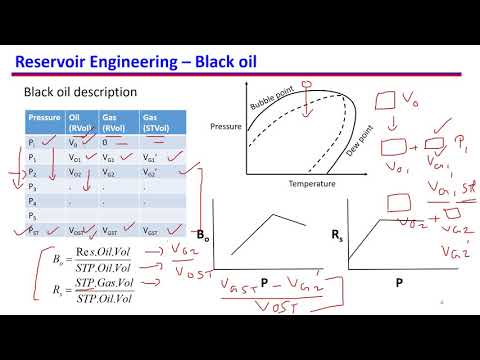

In [14]:
#@title  Formation volume factor and dissolved gas oil ratio
#@markdown Introduction to formation volume factor and dissolved gas oil ratio. Oil formation volume factor  is defined as the ratio of the volume of oil at reservoir (in-situ) conditions to that at stock tank (surface) conditions.  This factor, is used to convert the flow rate of oil (at stock tank conditions) to reservoir conditions.
from IPython.display import YouTubeVideo
YouTubeVideo('QHgjMlyePvU', width=600, height=400)

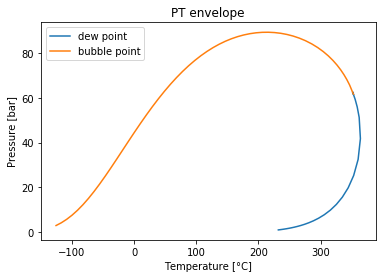

In [15]:
#@title Phase Envelope of a black oil

from neqsim.thermo import fluid, TPflash

nitrogen = 0.20 #@param {type:"number"}
CO2 = 1.3 #@param {type:"number"}
methane = 20.3  #@param {type:"number"}
ethane = 5.0  #@param {type:"number"}
propane =  2.5 #@param {type:"number"}
ibutane =  1.25 #@param {type:"number"}
nbutane =  1.25 #@param {type:"number"}
ipentane =  1.25 #@param {type:"number"}
npentane =  1.25 #@param {type:"number"}
C6 =  5.1 #@param {type:"number"}
C7 =  7.1 #@param {type:"number"}
C8 =  10.1 #@param {type:"number"}
C9 =  12.1 #@param {type:"number"}
C10plus =  20.1 #@param {type:"number"}

fluid1 = fluid('srk')
fluid1.addComponent("nitrogen", nitrogen)
fluid1.addComponent("CO2", CO2)
fluid1.addComponent("methane", methane)
fluid1.addComponent("ethane", ethane)
fluid1.addComponent("propane", propane)
fluid1.addComponent("i-butane", ibutane)
fluid1.addComponent("n-butane", nbutane)
fluid1.addComponent("i-pentane", ipentane)
fluid1.addComponent("n-pentane", npentane)
fluid1.addTBPfraction("C6", C6, 0.08, 0.61)
fluid1.addTBPfraction("C7", C7, 0.1, 0.7)
fluid1.addTBPfraction("C8", C8, 0.11, 0.72)
fluid1.addTBPfraction("C9", C9, 0.15, 0.74)
fluid1.addPlusFraction("C10", C10plus, 0.25, 0.82)
fluid1.setMixingRule("classic")

thermoOps = neqsim.thermodynamicOperations.ThermodynamicOperations(fluid1)
thermoOps.calcPTphaseEnvelope()

plt.plot([x-273.15 for x in list(thermoOps.getOperation().get("dewT"))],list(thermoOps.getOperation().get("dewP")), label="dew point")
plt.plot([x-273.15 for x in list(thermoOps.getOperation().get("bubT"))],list(thermoOps.getOperation().get("bubP")), label="bubble point")
plt.title('PT envelope')
plt.xlabel('Temperature [\u00B0C]')
plt.ylabel('Pressure [bar]')
plt.legend()
plt.show()

# Oil viscosity
THe principal factors affecting viscosity are:

* Oil composition
* Temperature
* Dissolved gas
* Pressure

Viscosity increases with decreases in crude oil API gravity (assuming a constant Watson characterization factor) and decreases in temperature. The effect of solution gas is to reduce viscosity. Above saturation pressure, viscosity increases almost linearly with pressure.

# Oil Formation Volume Factor (Bo)
In pressure transient analysis the flow rate used in the calculations is defined assuming reservoir conditions.  Since the oil flow rate is generally measured at the surface, in stock tank barrels, this rate must be converted to reservoir conditions by multiplying the surface rate by the oil formation volume factor.

Below the bubble point pressure, the oil formation volume factor increases with pressure.  This is because more gas goes into solution as the pressure is increased causing the oil to swell.  Above the bubble point pressure, the oil formation volume factor decreases as the pressure is increased, because there is no more gas available to go into solution and the oil is compressed.

The value of the oil formation volume factor is generally between 1 and 2 Rbbl / stbbl (R m3 / st m3).  It is readily obtained from laboratory PVT measurements or may be calculated from correlations such as Vasquez and Beggs.  It is recommended that the value be evaluated at reservoir conditions at the average reservoir pressure at the time of the test.

 

Note that when calculating the oil formation volume factor from correlations, the solution gas oil ratio (Rs) has a significant effect on the value.

Text(0, 0.5, 'Viscosity [kg/ms]')

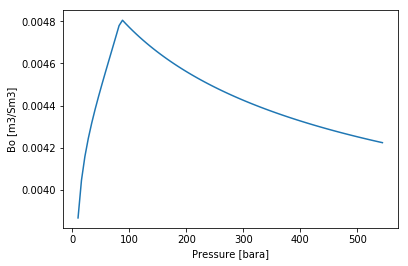

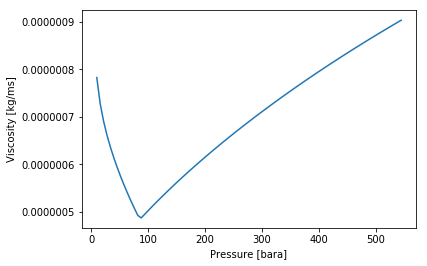

In [16]:
#@title  Calculation of formation volume factor and dissolved gas oil ratio
#@markdown Select temperature of reservoir, minimum and maximum pressure and composition of reservoir fluid.

temperature = 150.0   #@param {type:"number"}
minPressure = 10.0  #@param {type:"number"}
maxPressure = 550.0  #@param {type:"number"}

from neqsim.thermo import fluid, TPflash

def oilVolume(pressure, temperature):
    fluid1.setPressure(pressure)
    fluid1.setTemperature(temperature+273.15)
    TPflash(fluid1)
    fluid1.initPhysicalProperties();
    if(fluid1.hasPhaseType("oil")):
      return fluid1.getPhase("oil").getVolume()
    else:
      return fluid1.getVolume()

def oilViscosity(pressure, temperature):
    fluid1.setPressure(pressure)
    fluid1.setTemperature(temperature+273.15)
    TPflash(fluid1)
    fluid1.initPhysicalProperties();
    if(fluid1.hasPhaseType("oil")):
      return fluid1.getPhase("oil").getViscosity("cP")
    else:
      return fluid1.getViscosity("cP")

stdVol = oilVolume(1.01325, 288.15)

pressure = np.arange(minPressure, maxPressure, int((maxPressure-minPressure)/100)+1)
realdensity = [oilVolume(P,temperature)/stdVol for P in pressure]
viscosity = [oilViscosity(P,temperature)/stdVol for P in pressure]

plt.figure()
plt.plot(pressure, realdensity)
plt.xlabel('Pressure [bara]')
plt.ylabel('Bo [m3/Sm3]')

plt.figure()
plt.plot(pressure, viscosity)
plt.xlabel('Pressure [bara]')
plt.ylabel('Viscosity [cP]')

# Solution Gas-Oil Ratio (Rs)
The solution gas-oil ratio is the amount of gas dissolved in the oil at any pressure. It increases approximately linearly with pressure and is a function of the oil and gas composition. A heavy oil contains less dissolved gas than a light oil. In general, the solution gas-oil ratio varies from 0 (dead oil) to approximately 2000 scf/bbl (very light oil). The solution gas-oil ratio increases with pressure until the bubble point pressure is reached, after which it is a constant, and the oil is said to be undersaturated.

The solution gas-oil ratio is a significant component of the PVT correlations. It has a very significant influence on the oil formation volume factor, the oil viscosity, and the oil compressibility.

density 631.1648302109496


Text(0, 0.5, 'Rs [Sm3 gas/Sm3 oil]')

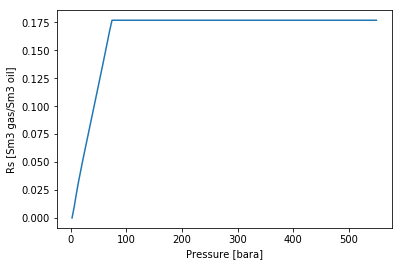

In [17]:
#@title  Calculation of formation volume factor and dissolved gas oil ratio
#@markdown Select temperature of reservoir, minimum and maximum pressure and composition of reservoir fluid.

temperature = 358.0   #@param {type:"number"}
minPressure = 1.0  #@param {type:"number"}
maxPressure = 550.0  #@param {type:"number"}


stdVol = oilVolume(1.01325, 288.15)

def gasVolume(pressure, temperature):
    fluid1.setPressure(pressure)
    fluid1.setTemperature(temperature)
    TPflash(fluid1)
    if(fluid1.getNumberOfPhases()>1):
      fluid1.removePhase(0)
    fluid1.setPressure(1.01325)
    fluid1.setTemperature(288.15)
    TPflash(fluid1)
    fluid1.initPhysicalProperties();
    if(fluid1.hasPhaseType("gas")):
      return fluid1.getPhase("gas").getVolume()
    else:
      return 0.0


pressure = np.arange(maxPressure, minPressure, int((minPressure-maxPressure)/100)+1)
Rs = [gasVolume(P,temperature)/stdVol for P in pressure]

TPflash(fluid1)
print("density "+str(fluid1.getDensity()))

plt.figure()
plt.plot(pressure, Rs)
plt.xlabel('Pressure [bara]')
plt.ylabel('Rs [Sm3 gas/Sm3 oil]')